In [1]:
# Box 1: Setup & imports

# Load core libraries for CNN training and image visuals
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torchvision.transforms import functional as F
import matplotlib.pyplot as plt

# Set seed for reproducibility
torch.manual_seed(1)

# Select GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [2]:
# Box 2: Dataset & transforms

# Folder containing the hog and not hog images
data_root = "hog_vs_not"

# Train transforms with light augmentation and required 500x500 resize
transform_train = transforms.Compose([
    transforms.RandomCrop((178, 178)),
    transforms.RandomHorizontalFlip(),
    transforms.Resize((500, 500)),
    transforms.ToTensor()
])

# Eval transforms with only resize
transform_eval = transforms.Compose([
    transforms.Resize((500, 500)),
    transforms.ToTensor()
])

# Load dataset before splitting
full_dataset = datasets.ImageFolder(
    root=data_root,
    transform=transform_train
)

# Show class names and total count
class_names = full_dataset.classes
print("Classes:", class_names)
print("Total images:", len(full_dataset))


Classes: ['hog', 'not_hog']
Total images: 46


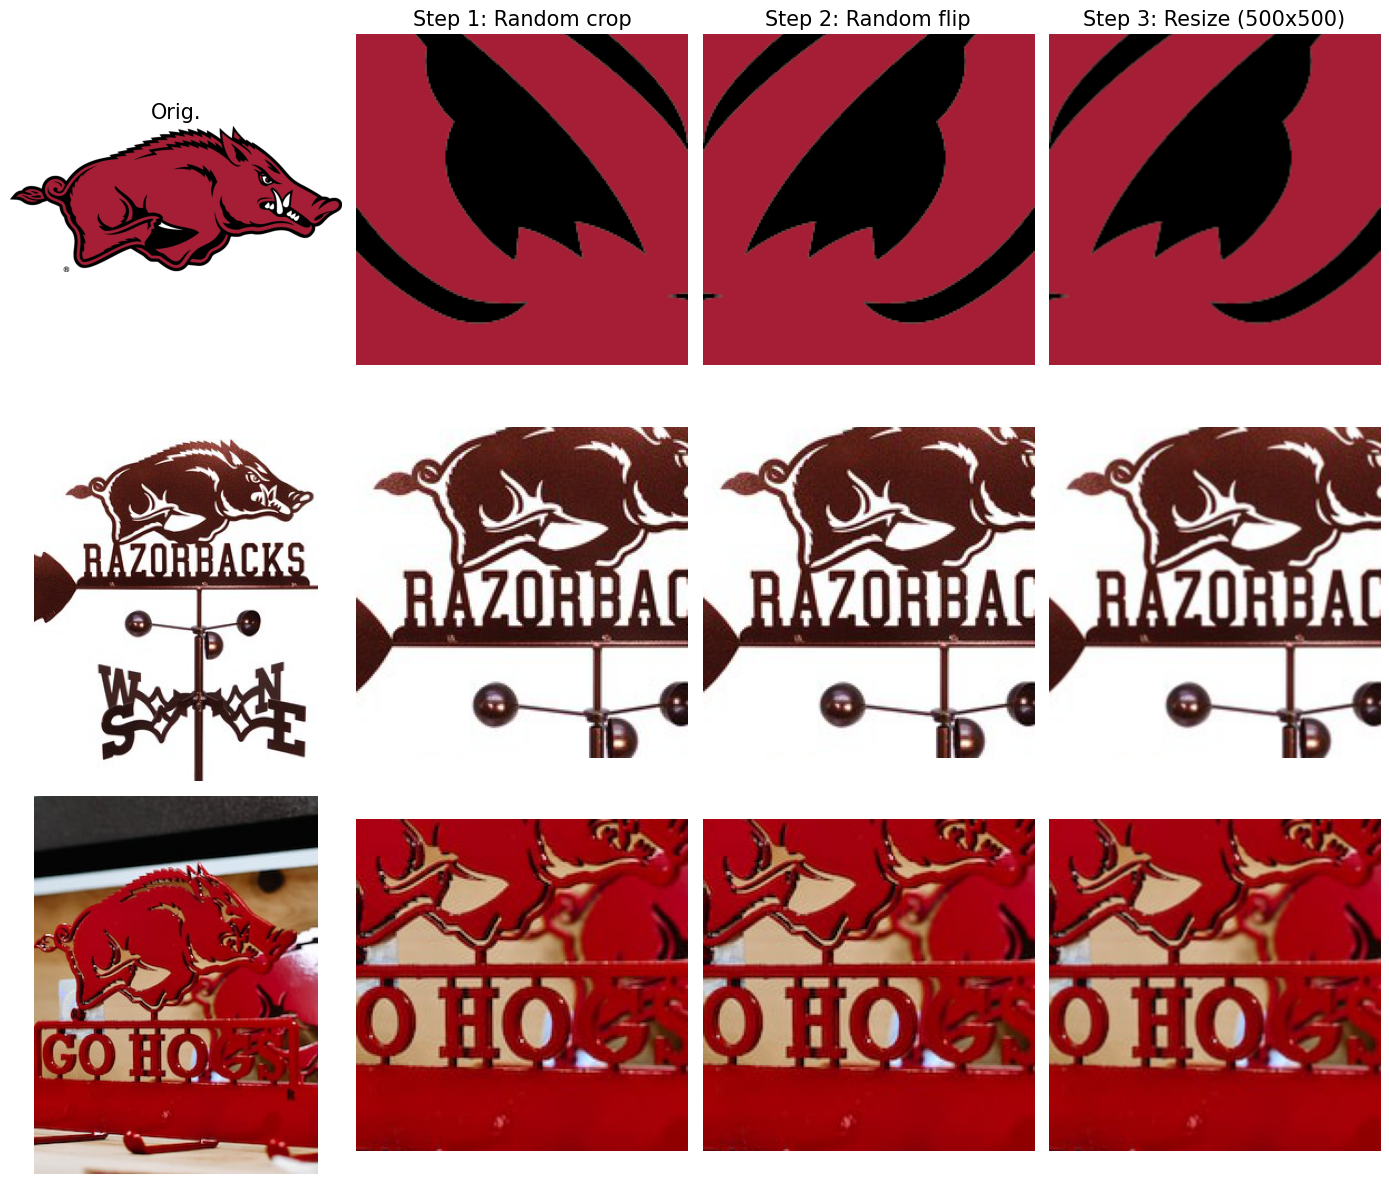

In [3]:
# Box 3: Visualize preprocessing steps on a few images

# Keep visuals consistent
torch.manual_seed(1)

# Setup figure layout
fig = plt.figure(figsize=(14, 12))

for i, (img, label) in enumerate(datasets.ImageFolder(root=data_root, transform=None)):

    # Show original image
    ax = fig.add_subplot(3, 4, i*4 + 1)
    ax.imshow(img)
    ax.axis("off")
    if i == 0:
        ax.set_title('Orig.', size=15)

    # Apply random crop
    ax = fig.add_subplot(3, 4, i*4 + 2)
    img_transform = transforms.Compose([transforms.RandomCrop([178, 178])])
    img_cropped = img_transform(img)
    ax.imshow(img_cropped)
    ax.axis("off")
    if i == 0:
        ax.set_title('Step 1: Random crop', size=15)

    # Apply random horizontal flip
    ax = fig.add_subplot(3, 4, i*4 + 3)
    img_transform = transforms.Compose([transforms.RandomHorizontalFlip()])
    img_flip = img_transform(img_cropped)
    ax.imshow(img_flip)
    ax.axis("off")
    if i == 0:
        ax.set_title('Step 2: Random flip', size=15)

    # Resize to 500x500
    ax = fig.add_subplot(3, 4, i*4 + 4)
    img_resized = F.resize(img_flip, size=(500, 500))
    ax.imshow(img_resized)
    ax.axis("off")
    if i == 0:
        ax.set_title('Step 3: Resize (500x500)', size=15)

    # Limit to 3 rows
    if i == 2:
        break

plt.tight_layout()
plt.show()


In [4]:
# Box 4: Train/validation split and DataLoaders

# Split dataset into train and validation sets
dataset_size = len(full_dataset)
val_size = int(0.2 * dataset_size)
train_size = dataset_size - val_size

train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Use eval transforms for validation images
val_dataset.dataset.transform = transform_eval

# Set batch size
batch_size = 8

# Build DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)

# Show split sizes
print(f"Train size: {len(train_dataset)}, Val size: {len(val_dataset)}")


Train size: 37, Val size: 9


In [5]:
# Box 5: CNN architecture

import torch.nn as nn

class HogCNN(nn.Module):
    def __init__(
        self,
        num_classes=2,
        channels=[16, 32, 64],
        pool_types="max",          # can use max or avg pooling
        conv_kernels=[3, 3, 3]     # kernel sizes for each conv layer
    ):
        super().__init__()

        # Normalize pool_types to a list
        if isinstance(pool_types, str):
            pool_types = [pool_types] * 3
        assert len(channels) == 3
        assert len(pool_types) == 3
        assert len(conv_kernels) == 3

        c1, c2, c3 = channels
        k1, k2, k3 = conv_kernels

        # Helper for picking pooling type
        def make_pool(ptype):
            if ptype == "max":
                return nn.MaxPool2d(2, 2)
            elif ptype == "avg":
                return nn.AvgPool2d(2, 2)
            else:
                raise ValueError(f"Unknown pool type: {ptype}")

        # Convolution blocks
        self.features = nn.Sequential(
            nn.Conv2d(3, c1, k1, padding=k1 // 2),
            nn.ReLU(),
            make_pool(pool_types[0]),

            nn.Conv2d(c1, c2, k2, padding=k2 // 2),
            nn.ReLU(),
            make_pool(pool_types[1]),

            nn.Conv2d(c2, c3, k3, padding=k3 // 2),
            nn.ReLU(),
            make_pool(pool_types[2]),
        )

        # Classifier for final prediction
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(c3 * 62 * 62, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Build model
model = HogCNN(num_classes=2).to(device)
print(model)


HogCNN(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=246016, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=2, bias=True)
  )
)


In [6]:
# Different CNN setups to compare during training

arch_configs = [
    # Small model with all max pooling
    {
        "name": "small_max",
        "channels": [16, 32, 64],
        "pool_types": ["max", "max", "max"],
        "conv_kernels": [3, 3, 3],
    },

    # Medium model with max pooling
    {
        "name": "medium_max",
        "channels": [32, 64, 128],
        "pool_types": ["max", "max", "max"],
        "conv_kernels": [3, 3, 3],
    },

    # Medium model with mixed pooling
    {
        "name": "medium_mix",
        "channels": [32, 64, 128],
        "pool_types": ["max", "avg", "max"],
        "conv_kernels": [3, 3, 3],
    },

    # Larger kernels and avg pooling
    {
        "name": "large_kernels_avg",
        "channels": [32, 64, 128],
        "pool_types": ["avg", "avg", "avg"],
        "conv_kernels": [5, 3, 3],
    },
]


In [7]:
# Loss function and initial setup
criterion = nn.CrossEntropyLoss()
num_epochs = 10  # small for testing

# Track best architecture
results = []
best_overall_state = None
best_overall_name = None
best_overall_val_acc = 0.0
best_overall_history = None

for cfg in arch_configs:
    print(f"\n=== Training architecture: {cfg['name']} ===")
    print(f"  channels={cfg['channels']}, pool={cfg['pool_types']}, kernels={cfg['conv_kernels']}")

    # Build model for this config
    model = HogCNN(
        num_classes=2,
        channels=cfg["channels"],
        pool_types=cfg["pool_types"],
        conv_kernels=cfg["conv_kernels"],
    ).to(device)

    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    # Track metrics per architecture
    train_losses_run, val_losses_run = [], []
    train_accs_run, val_accs_run = [], []
    best_val_acc_this_arch = 0.0

    for epoch in range(num_epochs):

        # --- TRAIN LOOP ---
        # Switch model to training mode
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        # Loop over training batches
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backprop and update weights
            loss.backward()
            optimizer.step()

            # Track loss and accuracy
            running_loss += loss.item() * labels.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        epoch_train_loss = running_loss / total
        epoch_train_acc = correct / total

        # --- VALIDATION LOOP ---
        # Switch to eval mode to disable dropout and grad tracking
        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0

        # No gradient updates during validation
        with torch.no_grad():
            # Loop over validation batches
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                # Track validation metrics
                val_running_loss += loss.item() * labels.size(0)
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

        epoch_val_loss = val_running_loss / val_total
        epoch_val_acc = val_correct / val_total

        # Store metrics for plots
        train_losses_run.append(epoch_train_loss)
        val_losses_run.append(epoch_val_loss)
        train_accs_run.append(epoch_train_acc)
        val_accs_run.append(epoch_val_acc)

        # Print progress for this epoch
        print(
            f"Epoch [{epoch+1}/{num_epochs}] "
            f"Train Loss: {epoch_train_loss:.4f}  Train Acc: {epoch_train_acc:.3f}  "
            f"Val Loss: {epoch_val_loss:.4f}  Val Acc: {epoch_val_acc:.3f}"
        )

        # Track best val accuracy for this architecture
        if epoch_val_acc > best_val_acc_this_arch:
            best_val_acc_this_arch = epoch_val_acc

    # Save summary for this architecture
    results.append({
        "name": cfg["name"],
        "channels": cfg["channels"],
        "pool_types": cfg["pool_types"],
        "conv_kernels": cfg["conv_kernels"],
        "best_val_acc": best_val_acc_this_arch,
    })

    # Update best overall architecture
    if best_val_acc_this_arch > best_overall_val_acc:
        best_overall_val_acc = best_val_acc_this_arch
        best_overall_name = cfg["name"]
        best_overall_state = model.state_dict()
        best_overall_history = (train_losses_run, val_losses_run, train_accs_run, val_accs_run)

# Show summary of all architectures
print("\n=== ARCHITECTURE SUMMARY ===")
for r in results:
    print(r)

print(f"\nBest architecture: {best_overall_name} with val_acc={best_overall_val_acc:.3f}")

# Restore best model for plotting and later use
model = HogCNN(
    num_classes=2,
    channels=[r for r in results if r["name"] == best_overall_name][0]["channels"],
    pool_types=[r for r in results if r["name"] == best_overall_name][0]["pool_types"],
    conv_kernels=[r for r in results if r["name"] == best_overall_name][0]["conv_kernels"],
).to(device)
model.load_state_dict(best_overall_state)

# Unpack training history
train_losses, val_losses, train_accs, val_accs = best_overall_history



=== Training architecture: small_max ===
  channels=[16, 32, 64], pool=['max', 'max', 'max'], kernels=[3, 3, 3]
Epoch [1/10] Train Loss: 0.6918  Train Acc: 0.595  Val Loss: 0.6653  Val Acc: 0.667
Epoch [2/10] Train Loss: 0.7862  Train Acc: 0.595  Val Loss: 0.7460  Val Acc: 0.333
Epoch [3/10] Train Loss: 0.6607  Train Acc: 0.595  Val Loss: 0.6681  Val Acc: 0.778
Epoch [4/10] Train Loss: 0.6013  Train Acc: 0.946  Val Loss: 0.6251  Val Acc: 0.889
Epoch [5/10] Train Loss: 0.5738  Train Acc: 0.703  Val Loss: 0.5878  Val Acc: 0.889
Epoch [6/10] Train Loss: 0.4994  Train Acc: 0.865  Val Loss: 0.6206  Val Acc: 0.778
Epoch [7/10] Train Loss: 0.4466  Train Acc: 0.973  Val Loss: 0.5338  Val Acc: 0.889
Epoch [8/10] Train Loss: 0.3804  Train Acc: 0.919  Val Loss: 0.4974  Val Acc: 0.889
Epoch [9/10] Train Loss: 0.3316  Train Acc: 0.946  Val Loss: 0.4585  Val Acc: 0.889
Epoch [10/10] Train Loss: 0.3221  Train Acc: 0.946  Val Loss: 0.4096  Val Acc: 0.889

=== Training architecture: medium_max ===
  c

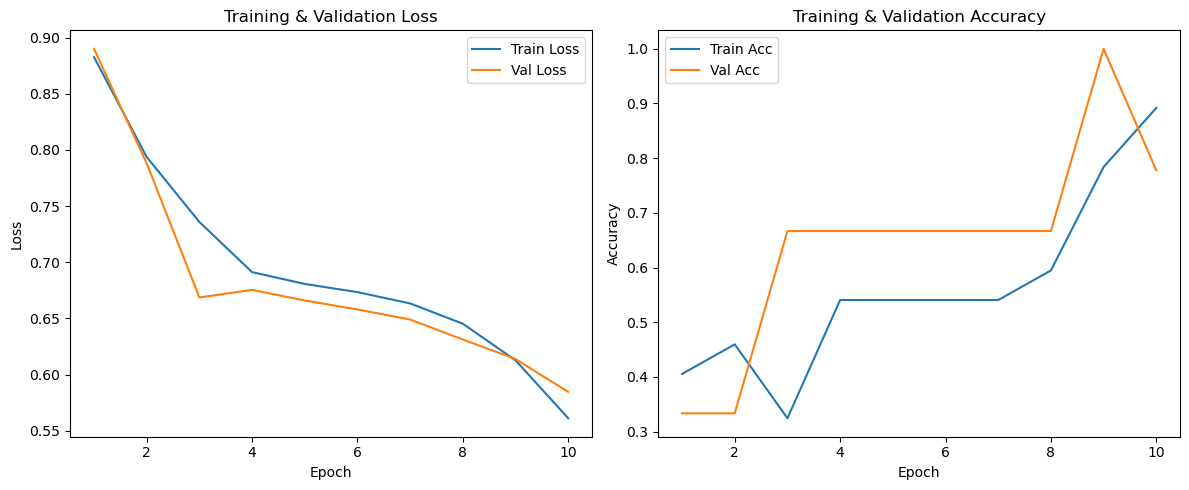

In [8]:
# Box 7: Plot loss and accuracy curves

# X axis for all plots
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

# Plot loss curves
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()

# Plot accuracy curves
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accs, label="Train Acc")
plt.plot(epochs, val_accs, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


In [9]:
# === Save best model ===
group_num = 25  # TODO: replace with your actual group number

save_path = f"Group_{group_num}_CNN_FullModel.ph"
torch.save({
    "model_state_dict": model.state_dict(),
    "best_arch_config": [r for r in results if r["name"] == best_overall_name][0],
}, save_path)

print("Saved best CNN model to:", save_path)


Saved best CNN model to: Group_25_CNN_FullModel.ph
